To understand the multimodal phenomenon of unsupervised [hidden Markov models](https://en.wikipedia.org/wiki/Hidden_Markov_model) (HMM) when reading [some discussions in PyMC discourse](https://discourse.pymc.io/t/how-to-marginalized-markov-chain-with-categorical/2230), I decide to reimplement in [Pyro](http://pyro.ai/) various [models from Stan](https://github.com/stan-dev/example-models/tree/master/misc/hmm). The main reference which we'll use is [Stan User's Guide](https://mc-stan.org/docs/2_18/stan-users-guide/hmms-section.html).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(palette="bright")
import torch
import warnings; warnings.simplefilter("ignore", FutureWarning)

# this post assumes a Pyro version in dev branch (dated 2019-01-01):
# pip install git+https://github.com/uber/pyro@4e42613
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, NUTS

pyro.set_rng_seed(1)

As in Stan user's guide, we use the notation `categories` for latent states and `words` for observations. The following data information is taken from Stan's [example-models repository](https://github.com/stan-dev/example-models/blob/master/misc/hmm/hmm.data.R).

In [2]:
num_categories = 3
num_words = 10
num_supervised_data = 100
num_data = 600

transition_prior = torch.empty(num_categories).fill_(1.)
emission_prior = torch.empty(num_words).fill_(0.1)

transition_prob = dist.Dirichlet(transition_prior).sample(torch.Size([num_categories]))
emission_prob = dist.Dirichlet(emission_prior).sample(torch.Size([num_categories]))

We need to generate data randomly from the above transition probability and emission probability. In addition, we will generate an initial category from the equilibrium distribution of its Markov chain.
<!-- TEASER_END -->

In [3]:
def equilibrium(mc_matrix):
    n = mc_matrix.size(0)
    return (torch.eye(n) - mc_matrix.t() + 1).inverse().matmul(torch.ones(n))

start_prob = equilibrium(transition_prob)

# simulate data
categories, words = [], []
for t in range(num_data):
    if t == 0 or t == num_supervised_data:
        category = dist.Categorical(start_prob).sample()
    else:
        category = dist.Categorical(transition_prob[category]).sample()
    word = dist.Categorical(emission_prob[category]).sample()
    categories.append(category)
    words.append(word)
categories, words = torch.stack(categories), torch.stack(words)

# split into supervised data and unsupervised data
supervised_categories = categories[:num_supervised_data]
supervised_words = words[:num_supervised_data]
unsupervised_words = words[num_supervised_data:]

To observe the posterior, which are samples drawn from a Markov chain Monte Carlo sampling, we'll make a convenient plotting function.

In [4]:
def plot_posterior(mcmc):
    # get `transition_prob` samples from posterior
    trace_transition_prob = mcmc.get_samples()["transition_prob"]

    plt.figure(figsize=(10, 6))
    for i in range(num_categories):
        for j in range(num_categories):
            sns.distplot(trace_transition_prob[:, i, j], hist=False, kde_kws={"lw": 2},
                         label="transition_prob[{}, {}], true value = {:.2f}"
                         .format(i, j, transition_prob[i, j]))
    plt.xlabel("Probability", fontsize=13)
    plt.ylabel("Frequency", fontsize=13)
    plt.title("Transition probability posterior", fontsize=15)

## Supervised HMM

When we know all hidden states (categories), we can use a supervised HMM model. Implementing it in Pyro is quite straightforward (to get familiar with Pyro, please checkout [its tutorial page](http://pyro.ai/examples/)).

In [5]:
def supervised_hmm(categories, words):
    with pyro.plate("prob_plate", num_categories):
        transition_prob = pyro.sample("transition_prob", dist.Dirichlet(transition_prior))
        emission_prob = pyro.sample("emission_prob", dist.Dirichlet(emission_prior))

    category = categories[0]  # start with first category
    for t in range(len(words)):
        if t > 0:
            category = pyro.sample("category_{}".format(t), dist.Categorical(transition_prob[category]),
                                   obs=categories[t])
        pyro.sample("word_{}".format(t), dist.Categorical(emission_prob[category]), obs=words[t])

Sample: 100%|██████████| 200/200 [00:54,  3.70it/s, step size=5.18e-02, acc. prob=0.963]


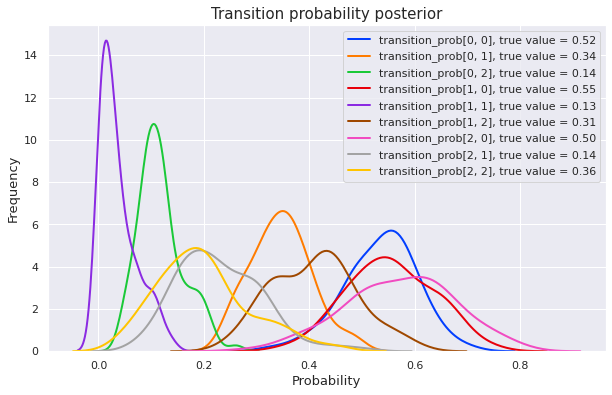

In [6]:
# enable jit_compile to improve the sampling speed
nuts_kernel = NUTS(supervised_hmm, jit_compile=True, ignore_jit_warnings=True)
mcmc = MCMC(nuts_kernel, num_samples=100)
# we run MCMC to get posterior
mcmc.run(supervised_categories, supervised_words)
# after that, we plot the posterior
plot_posterior(mcmc)

We can see that MCMC gives a good posterior in this supervised context. Let's see how things change for an unsupervised model.

## Unsupervised HMM

In this case, we don't know yet which categories generate observed words. These hidden states (categories) are discrete latent variables. Although Pyro supports [maginalizing out discrete latent variables](http://pyro.ai/examples/enumeration.html), we won't use that technique here because [it is slow for HMM](https://github.com/uber/pyro/issues/1511). We instead will use the [forward algorithm](https://en.wikipedia.org/wiki/Forward_algorithm) to reduce time complexity.

In [7]:
def forward_log_prob(prev_log_prob, curr_word, transition_log_prob, emission_log_prob):
    log_prob = emission_log_prob[:, curr_word] + transition_log_prob + prev_log_prob.unsqueeze(dim=1)
    return log_prob.logsumexp(dim=0)

In [8]:
def unsupervised_hmm(words):
    with pyro.plate("prob_plate", num_categories):
        transition_prob = pyro.sample("transition_prob", dist.Dirichlet(transition_prior))
        emission_prob = pyro.sample("emission_prob", dist.Dirichlet(emission_prior))

    transition_log_prob = transition_prob.log()
    emission_log_prob = emission_prob.log()
    log_prob = emission_log_prob[:, words[0]]
    for t in range(1, len(words)):
        log_prob = forward_log_prob(log_prob, words[t], transition_log_prob, emission_log_prob)
    prob = log_prob.logsumexp(dim=0).exp()
    # a trick to inject an additional log_prob into model's log_prob
    pyro.sample("forward_prob", dist.Bernoulli(prob), obs=torch.tensor(1.))

Sample: 100%|██████████| 200/200 [05:24,  1.62s/it, step size=1.52e-01, acc. prob=0.860]


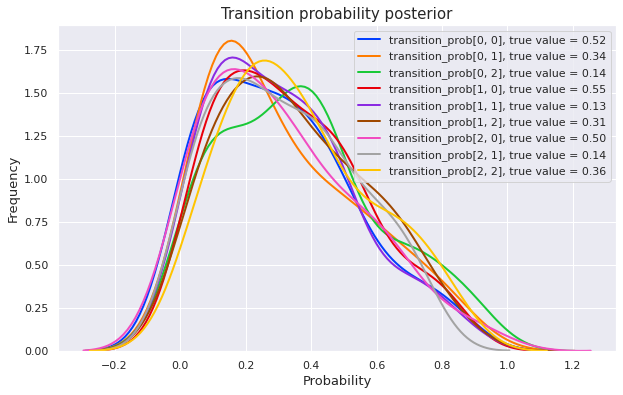

In [9]:
nuts_kernel = NUTS(unsupervised_hmm, jit_compile=True, ignore_jit_warnings=True)
mcmc = MCMC(nuts_kernel, num_samples=100)
mcmc.run(unsupervised_words)
plot_posterior(mcmc)

We can see that the posterior distributions highly spread over the interval $[0, 1]$ (though they seem to favor the first half). This posterior will not be useful for making further predictions.

## Semi-supervised HMM

To fix the above issue, we will use supervised data for inference.

In [10]:
def semisupervised_hmm(supervised_categories, supervised_words, unsupervised_words):
    with pyro.plate("prob_plate", num_categories):
        transition_prob = pyro.sample("transition_prob", dist.Dirichlet(transition_prior))
        emission_prob = pyro.sample("emission_prob", dist.Dirichlet(emission_prior))

    category = supervised_categories[0]
    for t in range(len(supervised_words)):
        if t > 0:
            category = pyro.sample("category_{}".format(t), dist.Categorical(transition_prob[category]),
                                   obs=supervised_categories[t])
        pyro.sample("word_{}".format(t), dist.Categorical(emission_prob[category]),
                    obs=supervised_words[t])

    transition_log_prob = transition_prob.log()
    emission_log_prob = emission_prob.log()
    log_prob = emission_log_prob[:, unsupervised_words[0]]
    for t in range(1, len(unsupervised_words)):
        log_prob = forward_log_prob(log_prob, unsupervised_words[t],
                                    transition_log_prob, emission_log_prob)
    prob = log_prob.logsumexp(dim=0).exp()
    pyro.sample("forward_prob", dist.Bernoulli(prob), obs=torch.tensor(1.))

Sample: 100%|██████████| 200/200 [10:20,  3.10s/it, step size=9.60e-02, acc. prob=0.857]


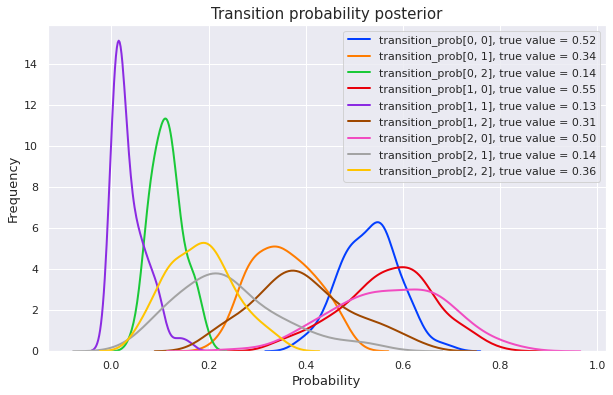

In [11]:
nuts_kernel = NUTS(semisupervised_hmm, jit_compile=True, ignore_jit_warnings=True)
mcmc = MCMC(nuts_kernel, num_samples=100)
mcmc.run(supervised_categories, supervised_words, unsupervised_words)
plot_posterior(mcmc)

The posterior is much better now. Which means that the additional information from supervised data has helped a lot!

## Some takeaways

+ When we don't have much labeled data, consider using [semi-supervised learning](https://en.wikipedia.org/wiki/Semi-supervised_learning).
+ Using additional algorithms (which include the **forward algorithm** in this case) can significantly improve the speed of our models.

For a variational inference approach to HMM, please check out [this excellent example](http://pyro.ai/examples/hmm.html) in Pyro tutorial page.